In [1]:
import re
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from transformers.file_utils import is_tf_available, is_torch_tpu_available, is_torch_available
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\timio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\timio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\timio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
train_data = pd.read_csv(r'new dataset.csv')
train_data = train_data.loc[:, ~train_data.columns.str.contains('^Unnamed')]
train_data

,text,class
0,21st Century Wire says A group of top Silicon ...,0
1,Paul Ryan said that the House would implement ...,0
2,About 66 million people are forcibly displaced...,1
3,If you ve been on the email list for President...,0
4,Berlin (Reuters) - Germany said on Friday it h...,1
...,...,...
29995,The former CEO of a local cybersecurity firm i...,0
29996,"MOSCOW (Reuters) - Mikhail Gorbachev, the last...",1
29997,Imagine being a woman going to a university wh...,0
29998,WASHINGTON (Reuters) - Ohio’s Republican gover...,1


In [3]:
# Data Preprocessing
def preprocessing_data(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')
    words = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([nltk.stem.WordNetLemmatizer().lemmatize(word) for word in words if word not in stopwords.words('english')])
    
    return text

In [4]:
train_data["text"] = train_data.text.apply(preprocessing_data)

<AxesSubplot:xlabel='class', ylabel='count'>

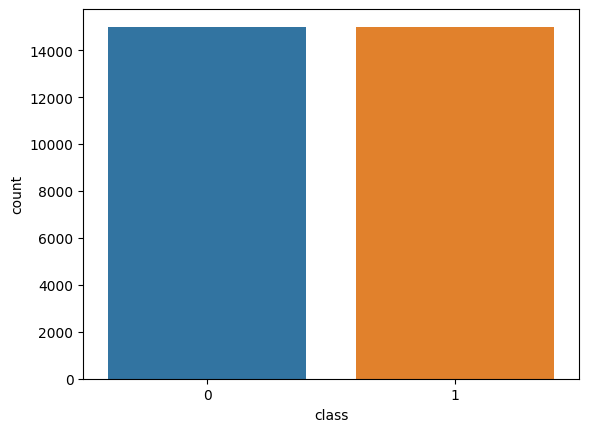

In [5]:
sns.countplot(data = train_data, x = 'class')

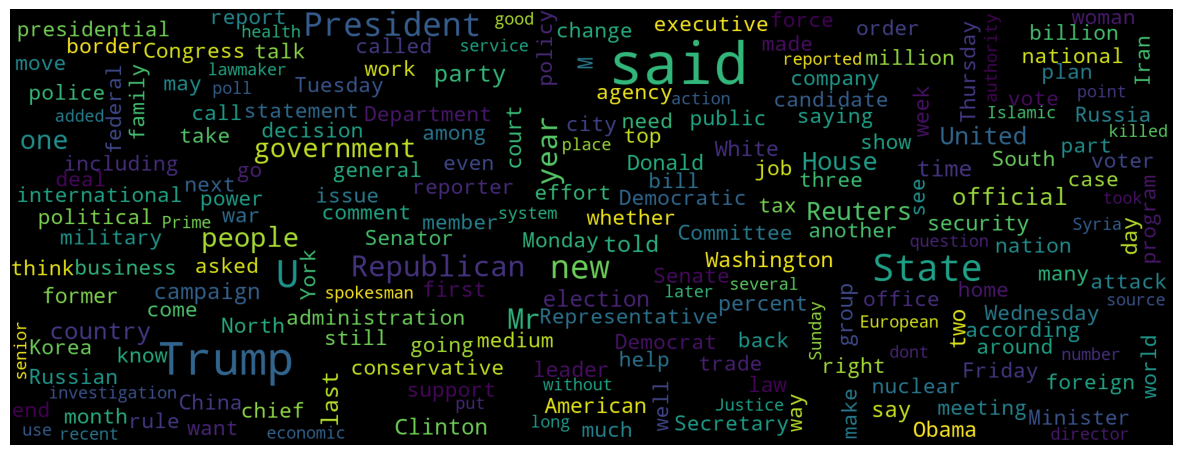

In [6]:
realCloud = ' '.join(train_data[train_data['class'] == 1]['text'])
words_cloud = WordCloud(background_color='black', min_font_size = 10, max_font_size = 100, include_numbers = False, collocations=False, width=2000, height=750)
plt.figure(figsize=(15, 30))
plt.imshow(words_cloud.generate(realCloud))
plt.axis('off')
plt.show()

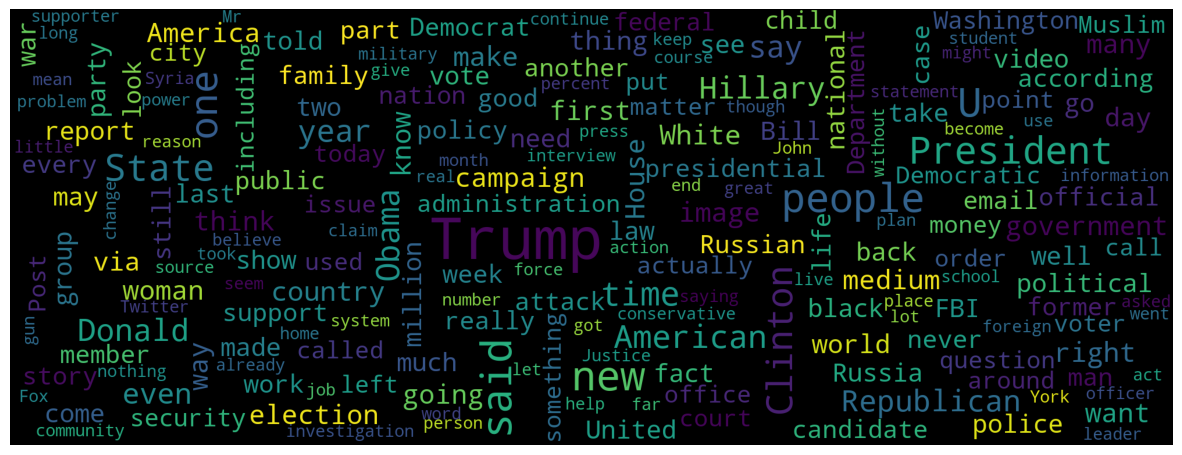

In [7]:
fakeCloud = ' '.join(train_data[train_data['class'] == 0]['text'])
words_cloud = WordCloud(background_color='black', min_font_size = 10, max_font_size = 100, include_numbers = False, collocations=False, width=2000, height=750)
plt.figure(figsize=(15, 30))
plt.imshow(words_cloud.generate(fakeCloud))
plt.axis('off')
plt.show()

In [8]:
import matplotlib.pyplot as plt

def n_grams(corpus, ylabel, title, n=2):
    ngrams_corpus = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:10]
    ngrams_corpus.sort_values().plot.barh(width=.8, color='cyan', figsize=(15, 10))
    plt.xlabel('Frequency')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    

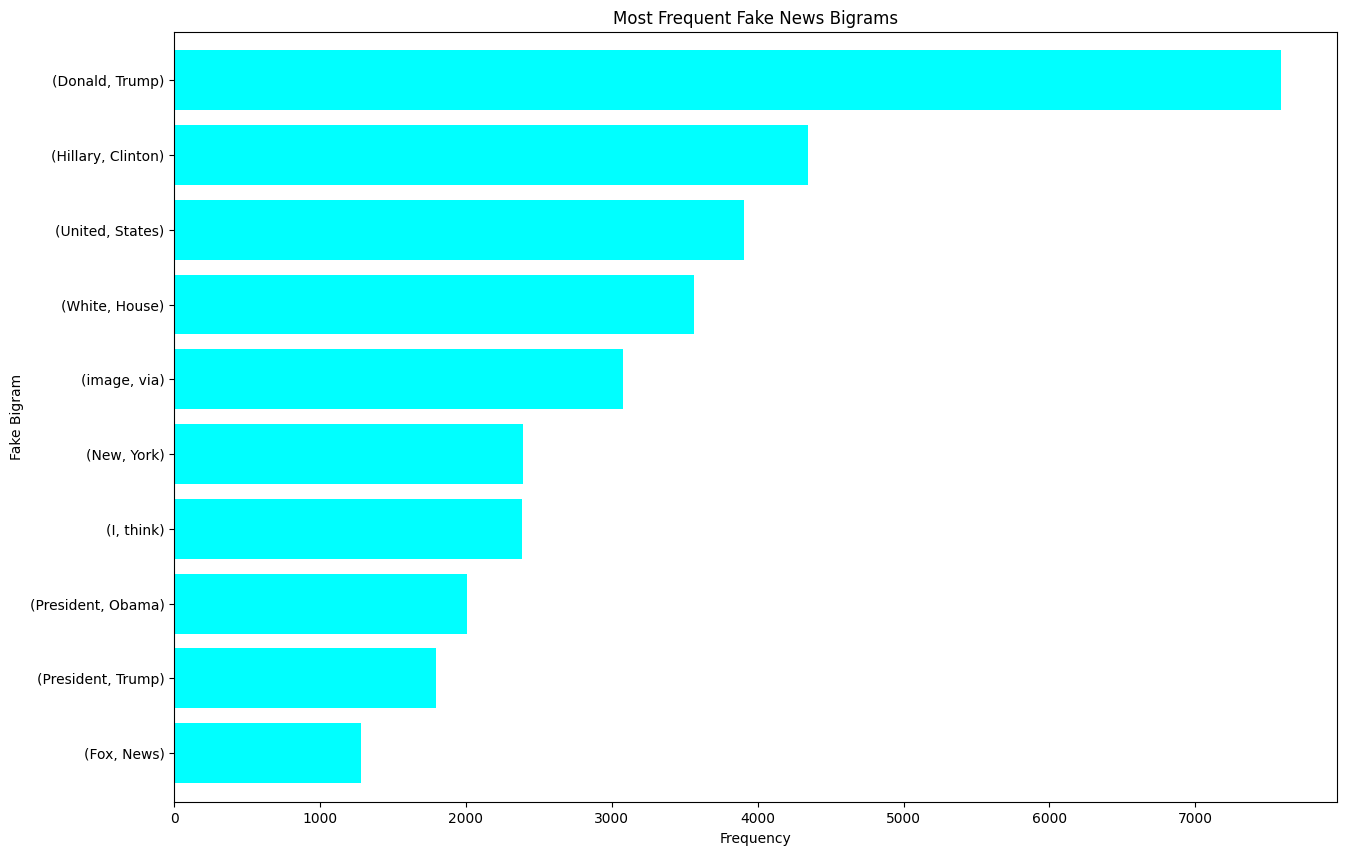

In [9]:
n_grams(fakeCloud, 'Fake Bigram', 'Most Frequent Fake News Bigrams', n=2)

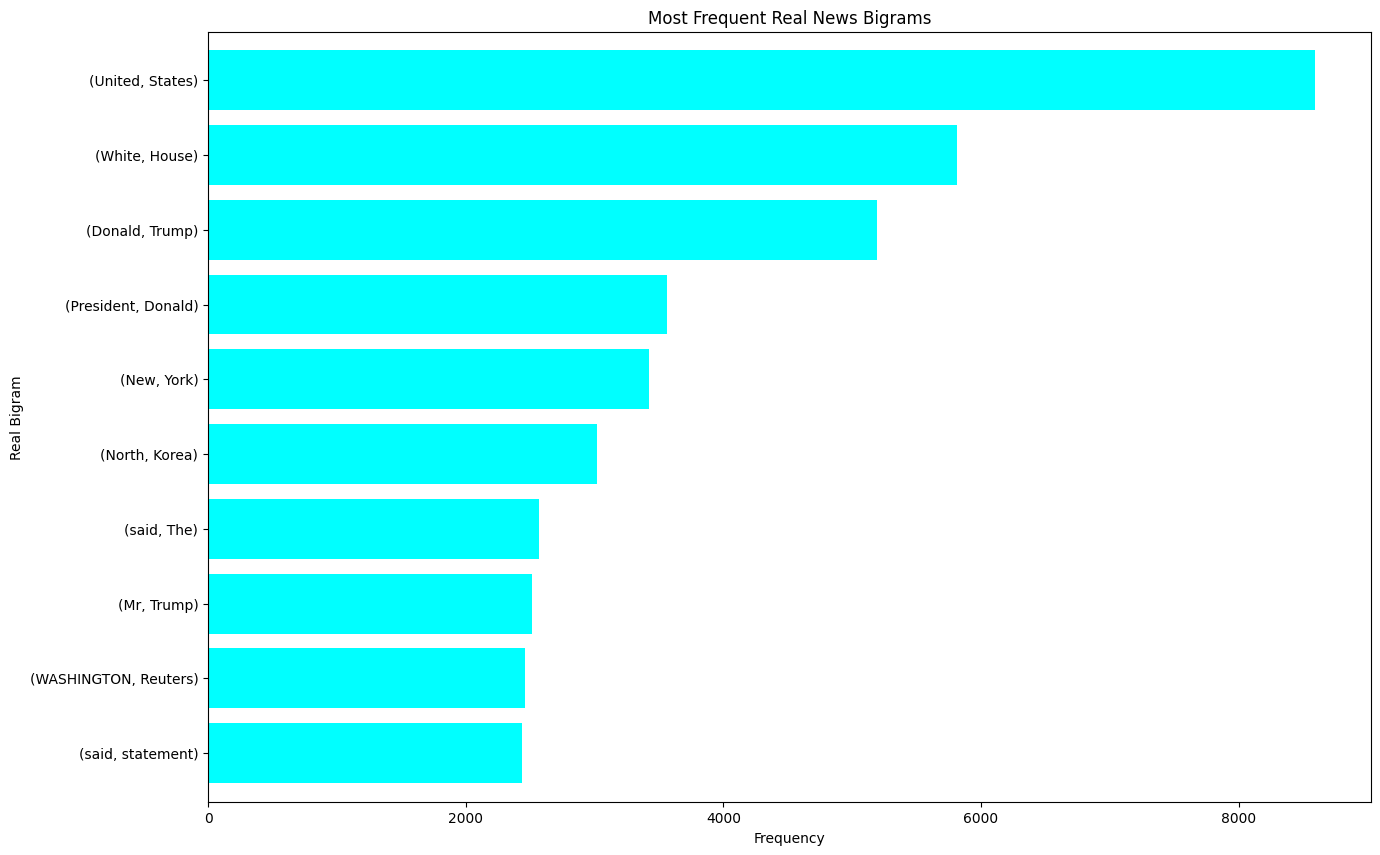

In [10]:
n_grams(realCloud, 'Real Bigram', 'Most Frequent Real News Bigrams', n=2)

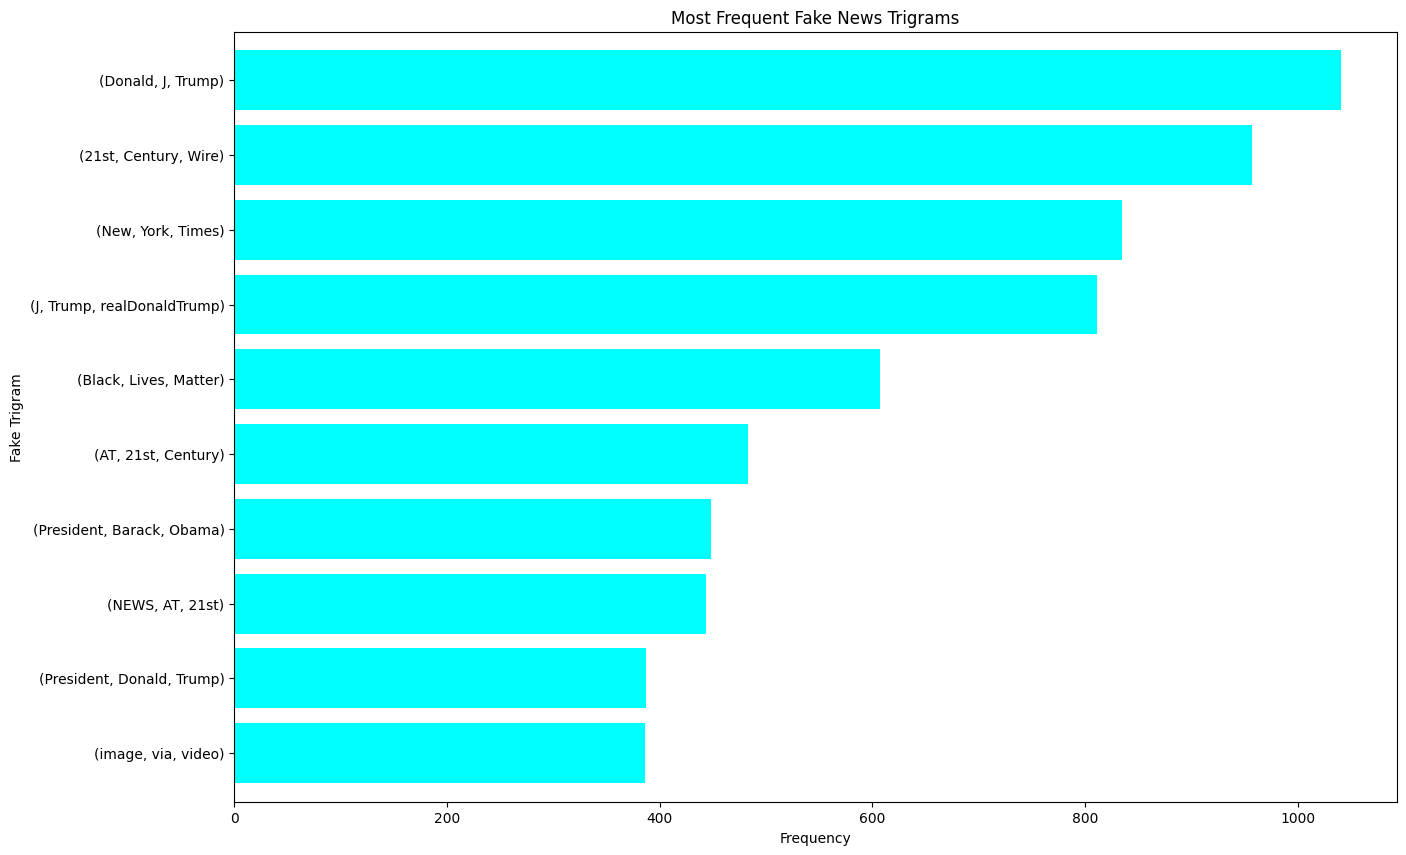

In [11]:
n_grams(fakeCloud, 'Fake Trigram', 'Most Frequent Fake News Trigrams', n=3)

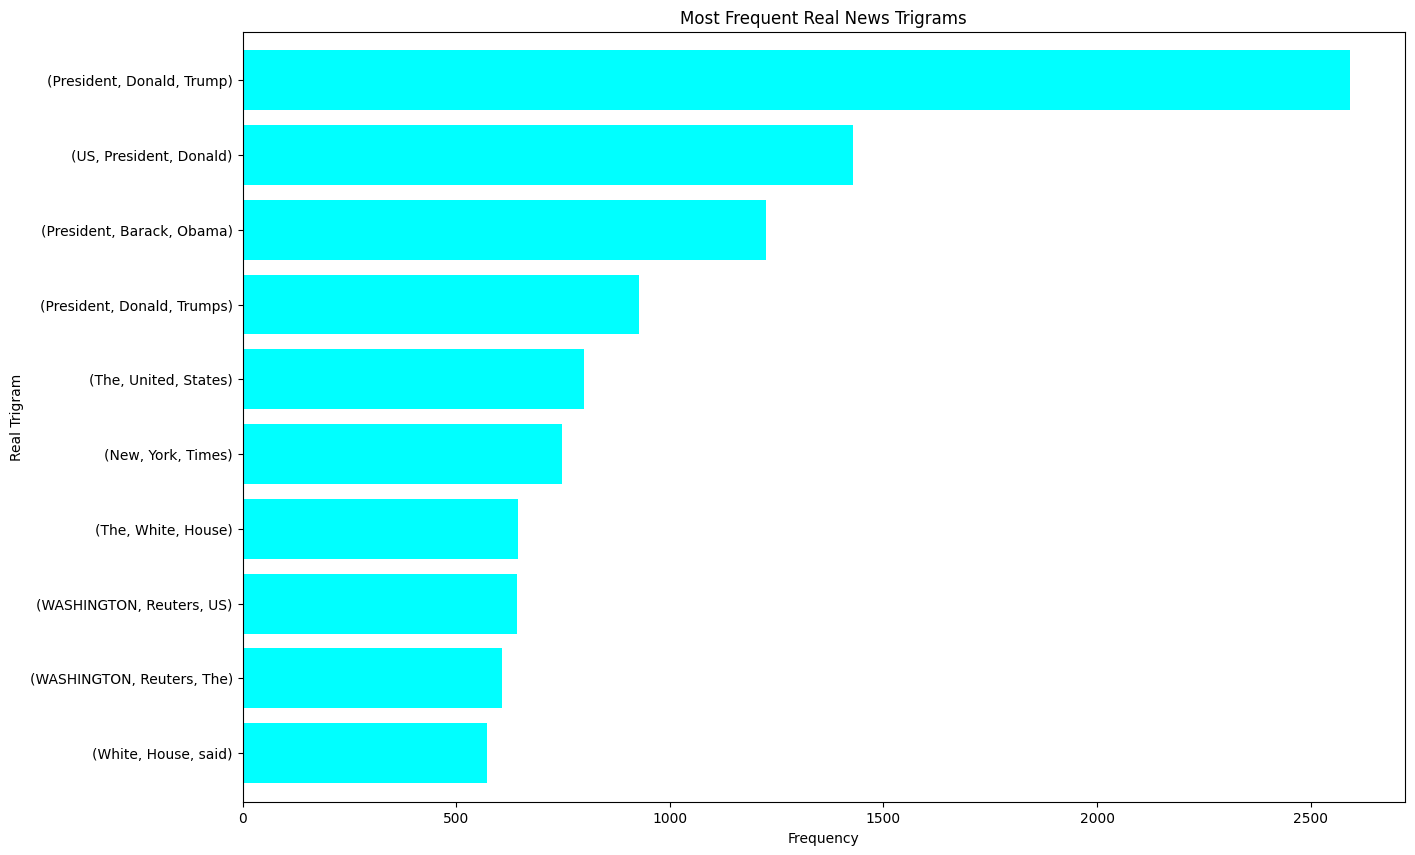

In [12]:
n_grams(realCloud, 'Real Trigram', 'Most Frequent Real News Trigrams', n=3)

In [13]:
from transformers import BertTokenizerFast

training_model = "bert-base-uncased"
max_doc_token_length = 512

bert_token = BertTokenizerFast.from_pretrained(training_model, do_lower_case=True)

In [14]:
def data_set(train_data, test_size=0.1):
    
    texts = []
    labels = []
    
    for i in range(len(train_data)):
        
        text = train_data["text"].iloc[i]
        class1 =  train_data["class"].iloc[i]
        if text and class1 in [0, 1]:
            
            texts.append(text)
            labels.append(class1)
    return train_test_split(texts, labels, test_size=test_size)

training_texts, auth_texts, training_classes, auth_classes = data_set(train_data)
# classes = train_data.class
#training_classes, auth_classes, training_texts, auth_texts = train_test_split(train_data['text'], train_data['class'], test_size=0.1, random_state=10)

In [15]:
print(len(training_texts), len(training_classes))
print(len(auth_texts), len(auth_classes))

26828 26828
2981 2981


In [16]:
encoded_training = bert_token(training_texts, padding=True, truncation=True, max_length=max_doc_token_length)
encoded_auth = bert_token(auth_texts, padding=True, truncation=True, max_length=max_doc_token_length)

In [17]:
# Converting encodings into a Dataset object
from torch.utils.data import Dataset

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels=labels
    
    def __getitem__(self, idx):
        item = {keys: torch.tensor(value[idx]) for keys, value in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)


    
new_train_data = NewsDataset(encoded_training, training_classes)
new_auth_data = NewsDataset(encoded_auth, auth_classes)

In [18]:
#import tensorflow as tf
from transformers import BertForSequenceClassification, TFTrainer, TFTrainingArguments

def accuracy_metrics(predict):
    #ccuracy = accuracy_score(predict.class_ids, predict.predictions.argmax(-1))
    labels = predict.label_ids
    pred = predict.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, pred)
    
    return {"Accuracy": accuracy,}

new_train_model = BertForSequenceClassification.from_pretrained(training_model, num_labels=2)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
args = TrainingArguments(output_dir='./Training Output',
                         num_train_epochs=1,
                         per_device_train_batch_size=8,
                         per_device_eval_batch_size=20,
                         warmup_steps=200,
                         logging_dir='./logs',
                         logging_steps=300,
                         save_steps=300,
                         evaluation_strategy="steps",
                         load_best_model_at_end=True
)

news_trainer = Trainer(model=new_train_model, args=args, train_dataset=new_train_data, eval_dataset=new_auth_data, compute_metrics=accuracy_metrics)

news_trainer.train()

c:\users\timio\appdata\local\programs\python\python37\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 26828
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3354
  Number of trainable parameters = 109483778


Step,Training Loss,Validation Loss,Accuracy
300,0.366900,0.253364,0.951359
600,0.219300,0.135498,0.962764
900,0.144100,0.132767,0.969473
1200,0.132300,0.150186,0.964777
1500,0.139500,0.083283,0.977524
1800,0.069900,0.095367,0.979202
2100,0.082400,0.084322,0.979873
2400,0.084900,0.067416,0.980879
2700,0.088600,0.059153,0.985911
3000,0.078300,0.062034,0.983898


***** Running Evaluation *****
  Num examples = 2981
  Batch size = 20
Saving model checkpoint to ./Training Output\checkpoint-300
Configuration saved in ./Training Output\checkpoint-300\config.json
Model weights saved in ./Training Output\checkpoint-300\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2981
  Batch size = 20
Saving model checkpoint to ./Training Output\checkpoint-600
Configuration saved in ./Training Output\checkpoint-600\config.json
Model weights saved in ./Training Output\checkpoint-600\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2981
  Batch size = 20
Saving model checkpoint to ./Training Output\checkpoint-900
Configuration saved in ./Training Output\checkpoint-900\config.json
Model weights saved in ./Training Output\checkpoint-900\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2981
  Batch size = 20
Saving model checkpoint to ./Training Output\checkpoint-1200
Configuration saved in ./Training Output\checkpoi

TrainOutput(global_step=3354, training_loss=0.1324651999777815, metrics={'train_runtime': 223653.9985, 'train_samples_per_second': 0.12, 'train_steps_per_second': 0.015, 'total_flos': 7058743393198080.0, 'train_loss': 0.1324651999777815, 'epoch': 1.0})

In [20]:
news_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2981
  Batch size = 20


{'eval_loss': 0.057946912944316864,
 'eval_Accuracy': 0.9872525997987253,
 'eval_runtime': 6783.9743,
 'eval_samples_per_second': 0.439,
 'eval_steps_per_second': 0.022,
 'epoch': 1.0}

In [28]:
def news_pred(text, convert_to_label=False):
    news_in = bert_token(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    news_out = new_train_model(**news_in)
    probs = news_out[0].softmax(1)
    label = {1: "Fake", 0: "Real"}
    if convert_to_label:
        return label[int(probs.argmax())]
    else:
        return int(probs.argmax())

In [30]:
news_input = str(input())

news_pred(news_input, convert_to_label=True)

Dr. Anthony Fauci “admitted” in a recent interview that face masks were a “failure.”  THE FACTS: Social media posts are misrepresenting what Fauci said about masks and COVID-19 and omitting part of his response. The nation’s former top infectious disease expert said mask initiatives may have a small impact at the community level, but in the following sentence he said he believes a properly worn, high-quality mask can be effective protection for an individual. The remarks were made in an interview published by The New York Times Magazine this week, months after Fauci stepped down from his post as director of the National Institute of Allergy and Infectious Diseases. One tweet claims: “Now Fauci admits masks don’t work after forcing them on kids.” “So yesterday Fauci publicly admitted masks were a failure,” reads a caption on an Instagram post that received more than 6,000 likes. The post included an image quoting Fauci as saying “masks work at the margins — maybe 10 percent.” But Fauci 

'Fake'